# Spike Sorting

### Declaring needed libraries and setting global windowSize

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
windowSize = 0.002 * 24414
windowSize = int(windowSize)

### Reading the given data and storing it in a dataframe
##### Each column is an electrode, electrode 1 is the first column, electrode 2 is the second

In [16]:
df = pd.read_csv("data.txt", delimiter='	')
df.columns = ['first','second']
first, second =  df['first'],df['second']

In [17]:
first

0          7.370100e-06
1         -9.368400e-06
2         -1.659100e-05
3         -1.183000e-05
4         -1.696100e-06
               ...     
4417518    4.372900e-07
4417519    1.735100e-06
4417520   -6.696300e-07
4417521   -6.815500e-06
4417522   -9.699100e-06
Name: first, Length: 4417523, dtype: float64

In [18]:
second

0          0.000002
1          0.000005
2          0.000007
3          0.000006
4          0.000005
             ...   
4417518   -0.000003
4417519   -0.000004
4417520    0.000007
4417521    0.000017
4417522    0.000012
Name: second, Length: 4417523, dtype: float64

### Extracting the features of each electrode

First we compute the threshold to block the noise: this is done by multiplying the std of the first 500 samples by 3.5

The window, which is based on the threshold and the given window size is computed, and from there the std and the maximum difference between two successive samples of the spikes are computed, the index of the maximum peak is also computed and stored for later use

In [19]:
def extractFeatures(df,windowSize):
    featureList = []
    threshold = 3.5 * df[:499].std(axis=0)
    arr = df.to_numpy()
    i = 0
    while i < len(arr):
        if arr[i] > threshold:
            j = i
            maximum = arr[i]
            maxInd = i
            while(arr[j] > threshold):
                if arr[j] > maximum:
                    maximum = arr[j]
                    maxInd = j
                j+=1
                
            start = int(max(0, maxInd - windowSize // 2))
            end = int(min(len(arr), maxInd + windowSize // 2))
            
            window = arr[int(start):int(end)]
            std = np.std(window)
            diff = np.max(np.abs(np.diff(window)))
            featureList.append({'std': std, 'diff': diff,'peakIndex' : maxInd })
            i = end
        else:
            i += 1
    featuresDF = pd.DataFrame(featureList)
    return featuresDF

In [20]:
features1 = extractFeatures(first, windowSize)
features1

,std,diff,peakIndex
0,0.000015,0.000028,745
1,0.000011,0.000019,1226
2,0.000025,0.000054,1793
3,0.000014,0.000016,2025
4,0.000015,0.000018,3236
...,...,...,...
4518,0.000011,0.000023,4416143
4519,0.000020,0.000048,4416708
4520,0.000014,0.000017,4416735
4521,0.000024,0.000051,4416937


In [21]:
features2 = extractFeatures(second, windowSize)
features2

,std,diff,peakIndex
0,0.000018,0.000030,1814
1,0.000012,0.000011,2837
2,0.000019,0.000034,3542
3,0.000022,0.000030,4385
4,0.000021,0.000034,4414
...,...,...,...
2040,0.000015,0.000012,4404890
2041,0.000010,0.000012,4409131
2042,0.000010,0.000012,4413009
2043,0.000011,0.000015,4413334


### Plotting the extracted features of each electrode spike

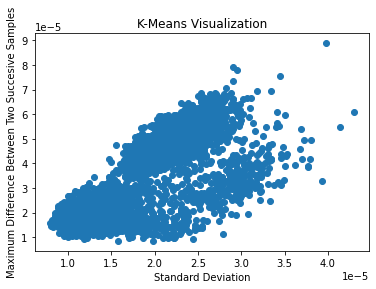

In [31]:
plt.scatter(features1['std'], features1['diff'])
plt.xlabel('Standard Deviation')
plt.ylabel('Maximum Difference Between Two Succesive Samples')
plt.title('K-Means Visualization')
plt.show()

By visual inspection of the plotted features, we can identify 3 clusters for electrode 1.

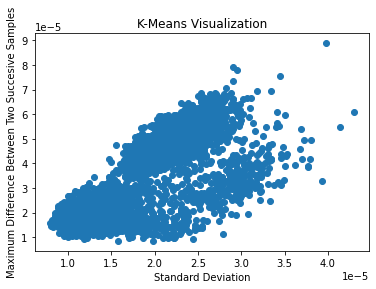

In [32]:
plt.scatter(features1['std'], features1['diff'])
plt.xlabel('Standard Deviation')
plt.ylabel('Maximum Difference Between Two Succesive Samples')
plt.title('K-Means Visualization')
plt.show()

By visual inspection of the plotted features, we can identify 3 clusters for electrode 2.

### Identifying the clusters programatically

In [33]:
def addCluster(features):
    X = features[['diff', 'std']]
    kmeans = KMeans(n_clusters=3)
    features['cluster'] = kmeans.fit_predict(X)
    #the below will make sure the neuron cluster is always consitent ie neuron 0 wont be top in first but bottom in second
    clusterMean = features.groupby('cluster').mean().sort_values('diff')['diff'].index
    mapCluster = {cluster: i for i, cluster in enumerate(clusterMean)}
    features['cluster'] = features['cluster'].map(mapCluster)
    
    return features

Here we use a machine learning algorithim, K-means-clusters to divide the spikes into 3 clusters. This adds another feature to the features dataframe which is the cluster category. We now know which neuron the spikes belong too.

In [34]:
features1 = addCluster(features1)
features2 = addCluster(features2)
features1

,std,diff,peakIndex,cluster
0,0.000015,0.000028,745,0
1,0.000011,0.000019,1226,0
2,0.000025,0.000054,1793,2
3,0.000014,0.000016,2025,0
4,0.000015,0.000018,3236,0
...,...,...,...,...
4518,0.000011,0.000023,4416143,0
4519,0.000020,0.000048,4416708,1
4520,0.000014,0.000017,4416735,0
4521,0.000024,0.000051,4416937,2


### Plotting the features after clustering

In [35]:
def plotFeatures(features):
    plt.scatter(features['std'], features['diff'], c=features['cluster'], cmap='plasma')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Maximum Difference Between Two Succesive Samples')
    plt.title('K-Means Visualization')
    plt.show()
    return features

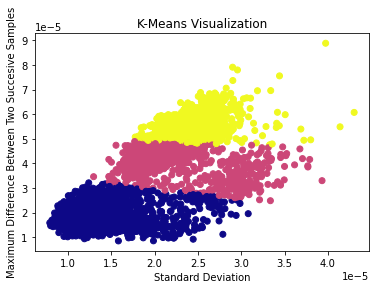

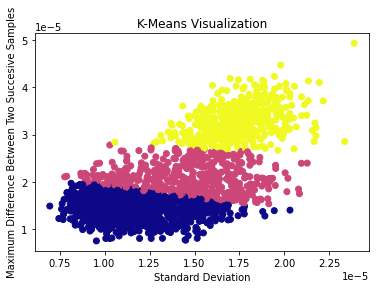

In [36]:
features1 = plotFeatures(features1)
features2 = plotFeatures(features2)

We can now tell which spike belongs to which neuron visually.

### Plotting the electrode signals, this time identifying the different neurons in which each spike belongs to

In [37]:
def plotSignal(Osignal,featuers):
    peaks = featuers['peakIndex'].values
    clusters = featuers['cluster'].values
    unique_clusters = np.unique(clusters)

    valid_indices = (peaks <= 20000) & (np.arange(len(clusters)) <= 20000)

    valid_peaks = peaks[valid_indices]
    valid_clusters = clusters[valid_indices]

    signal = Osignal.iloc[:20000].to_numpy()
    plt.plot(signal, label='Signal')

    cluster_colors = ['red', 'green', 'yellow'] 
    for i, cluster in enumerate(unique_clusters):
      cluster_peaks = valid_peaks[valid_clusters == cluster]
      plt.scatter(cluster_peaks, signal[cluster_peaks], label=f'Cluster {cluster}', color=cluster_colors[i], marker='o')

    plt.title(f'Signal with Clustered Peaks (First {20000} samples)')
    plt.xlabel('Peak')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.show()


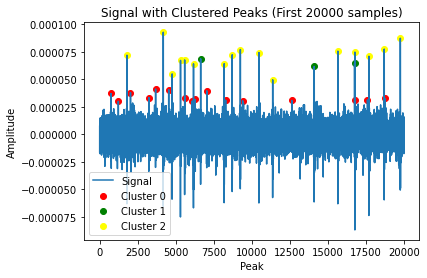

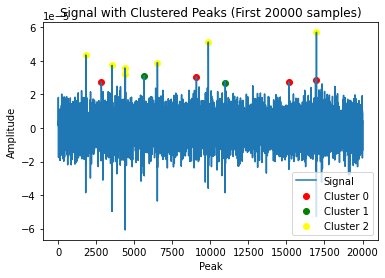

In [38]:
plotSignal(first, features1)
plotSignal(second, features2)

### Lastly we plot the average neuron spike for each neuron and for each electrode

This is done by taking half the window size to the right of the peak index and half a window size to the left of the peak index, and taking the average values of each cluster in that window, the values are then plotted on the graphs below

In [28]:
def plotAverageNeurons(feauture, data):
    clusters = np.unique(feauture["cluster"])

    color = ["#"+''.join([random.choice('0369CEF') for j in range(6)])
                for i in range(len(clusters))]

    avg_spikes = []
    for cluster in clusters:
        allSpikes = []
        for ind in feauture[feauture["cluster"] == cluster]["peakIndex"]:
            start = ind - 24
            end = ind + 24
            allSpikes.append([data[start:end]])
        avg_spikes.append(np.average(allSpikes, axis = 0)[0])

    indices = np.arange(len(avg_spikes[0]))
    for cluster in clusters:
        plt.plot(indices, avg_spikes[cluster], color=color[cluster], label="neuron "+str(cluster+1))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Single Spike Waveform')
    plt.legend()

    plt.grid(True)
    plt.show()


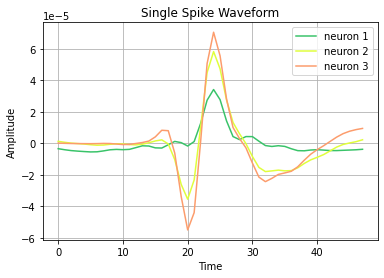

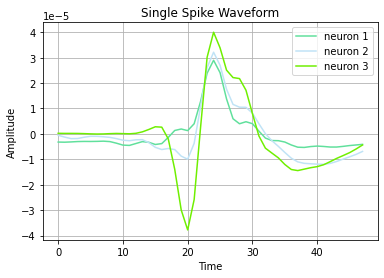

In [29]:
plotAverageNeurons(features1, first)
plotAverageNeurons(features2, second)